In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
sns.set_context('talk')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

In [2]:
log_directory = '../../../data/raw/logs/'

In [3]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [4]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size in Bytes"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [5]:
def producer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt/10"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["event"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
        variant_dfs["waiting"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_waiting_latency_timeline.csv"), skiprows=1)
        variant_dfs["staging"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_staging_latency_timeline.csv"), skiprows=1)
        variant_dfs["storing"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_storing_latency_timeline.csv"), skiprows=1)
        variant_dfs["committing"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_committing_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    return result

In [6]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

# Establish sustainable throughput

In [7]:
dataframes = producer_dfs(log_directory + "20200727/breakdown/")

In [8]:
def filter_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure][dataframes["exclusive"][measure]["Rate Limit in MB/s"] == 7400],
               dataframes["exclusive_opt"][measure][dataframes["exclusive_opt"][measure]["Rate Limit in MB/s"] == 7900],
               dataframes["concurrent"][measure][dataframes["concurrent"][measure]["Rate Limit in MB/s"] == 5300],
               dataframes["concurrent_opt/10"][measure][dataframes["concurrent_opt/10"][measure]["Rate Limit in MB/s"] == 5600]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    return pd.concat(df_list)

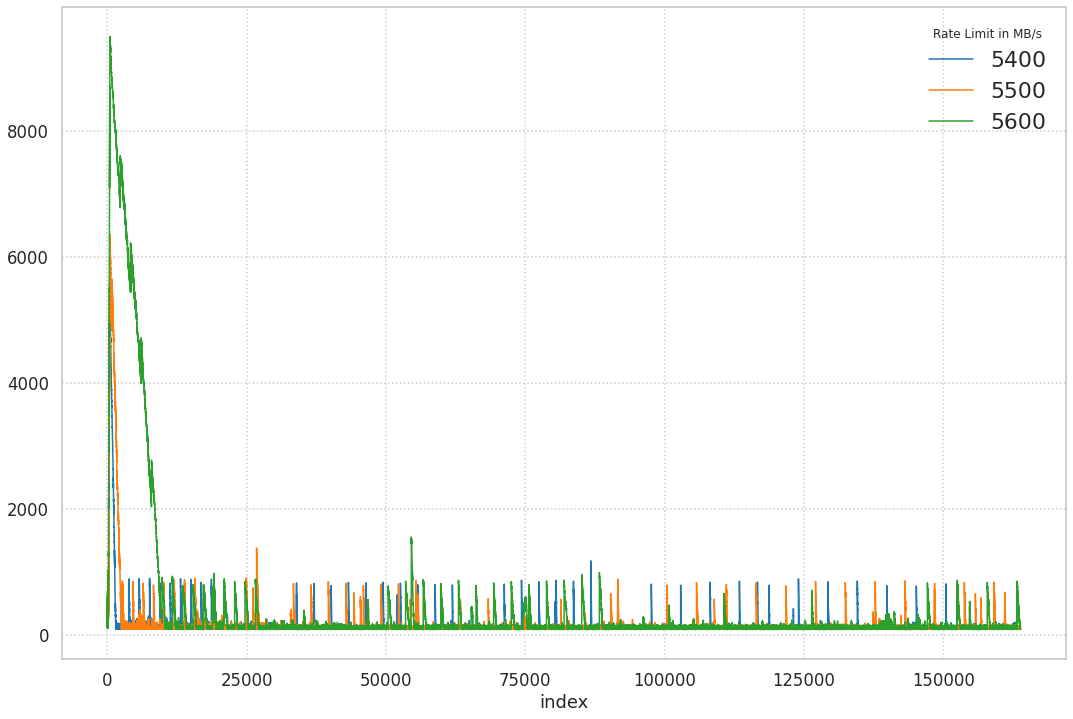

In [9]:
plot_timeseries(dataframes["concurrent_opt/10"]["event"][dataframes["concurrent_opt/10"]["event"]["Rate Limit in MB/s"] <= 5600], "Latency in us")

In [9]:
tp_df = filter_dfs(dataframes, "tp")

<ipython-input-8-53af36a22b68>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-8-53af36a22b68>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-8-53af36a22b68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [10]:
event_df = filter_dfs(dataframes, "event")
waiting_df = filter_dfs(dataframes, "waiting")
staging_df = filter_dfs(dataframes, "staging")
storing_df = filter_dfs(dataframes, "storing")
committing_df = filter_dfs(dataframes, "committing")

<ipython-input-8-53af36a22b68>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-8-53af36a22b68>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-8-53af36a22b68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [11]:
event_df["Step"] = "Total"
waiting_df["Step"] = "Wait"
staging_df["Step"] = "Stage"
storing_df["Step"] = "Store"
committing_df["Step"] = "Commit"

In [12]:
df = pd.concat([event_df, waiting_df, staging_df, storing_df, committing_df])
step_df = pd.concat([waiting_df,staging_df, storing_df, committing_df, event_df])

In [13]:
df.head()

,index,Latency in us,Message Size in Bytes,# of Segments,Rate Limit in MB/s,Protocol,Step
0,0,129,524288,90,7400,Excl.,Total
1,1,105,524288,90,7400,Excl.,Total
2,2,150,524288,90,7400,Excl.,Total
3,3,209,524288,90,7400,Excl.,Total
4,4,213,524288,90,7400,Excl.,Total


In [14]:
tp_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s,Protocol
0,0,14181,7434.928,524288,90,7400,Excl.
1,1,14388,7543.456,524288,90,7400,Excl.
2,2,14273,7483.163,524288,90,7400,Excl.
3,3,14267,7480.017,524288,90,7400,Excl.
4,4,14298,7496.270,524288,90,7400,Excl.


In [15]:
tp_df.groupby("Protocol").mean()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s
Protocol,,,,,,
Conc.,7.5,10205.500000,5350.621188,524288.0,90.0,5300.0
Conc. Opt.,7.0,10754.866667,5638.647667,524288.0,90.0,5600.0
Excl.,5.0,14279.636364,7486.642091,524288.0,90.0,7400.0
Excl. Opt.,5.0,14894.545455,7809.031364,524288.0,90.0,7900.0


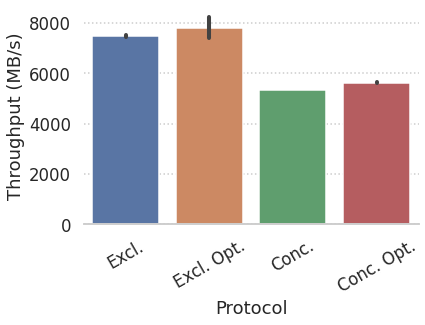

In [17]:
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Throughput in MB/s", hue="Protocol", data=tp_df, ci="sd", dodge=False)
sns.despine(left=True)
g.get_legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='center')
g.set_ylabel("Throughput (MB/s)")
g.get_figure().savefig("producer_breakdown_sust_tp.pdf", bbox_inches="tight", dpi=600)

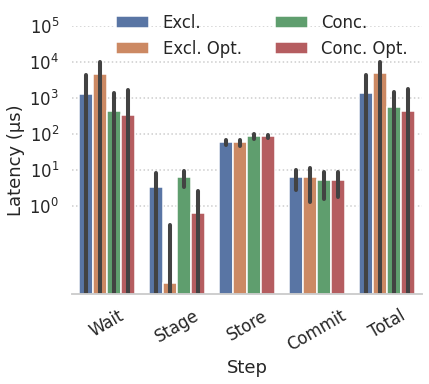

In [18]:
g = sns.catplot(x="Step", y="Latency in us", hue="Protocol", data=step_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
sns.despine(left=True)
g.set(yscale="log")
for ax in g.axes.flat:
    ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='center')
    ax.set_ylabel("Latency (μs)")
    ax.legend(loc="best", ncol=2, bbox_to_anchor=(0.,0.1, 1, 1))
g.savefig("producer_breakdown_100.pdf", bbox_inches="tight", dpi=600)

# Load factors

In [19]:
dataframes_75 = producer_dfs(log_directory + "20200727/breakdown/75/")

In [20]:
dataframes_50 = producer_dfs(log_directory + "20200727/breakdown/50/")

In [21]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt/10"][measure]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    return pd.concat(df_list)

In [22]:
def prepare_breakdown(dataframes):
    waiting_df = prepare_dfs(dataframes, "waiting")
    staging_df = prepare_dfs(dataframes, "staging")
    storing_df = prepare_dfs(dataframes, "storing")
    committing_df = prepare_dfs(dataframes, "committing")
    total_df = prepare_dfs(dataframes, "event")
    waiting_df["Step"] = "Wait"
    staging_df["Step"] = "Stage"
    storing_df["Step"] = "Store"
    committing_df["Step"] = "Commit"
    total_df["Step"] = "Total"
    return pd.concat([waiting_df, staging_df, storing_df, committing_df, total_df])

In [24]:
step_df_75 = prepare_breakdown(dataframes_75)

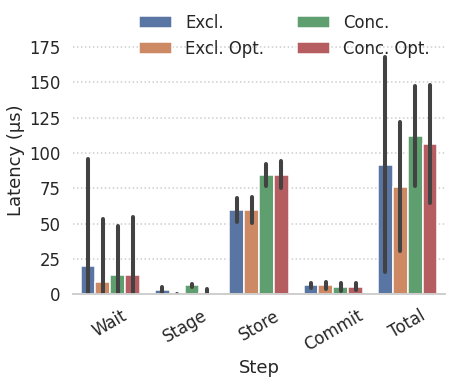

In [25]:
g = sns.catplot(x="Step", y="Latency in us", hue="Protocol", data=step_df_75, ci="sd", kind="bar",aspect=4./3, legend_out=False)
sns.despine(left=True)
g.set(ylim=(0, 190))
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='center')
    ax.set_ylabel("Latency (μs)")
    ax.legend(loc="best", ncol=2, bbox_to_anchor=(0.,0.1, 1, 1))
g.savefig("producer_breakdown_75.pdf", bbox_inches="tight", dpi=600)

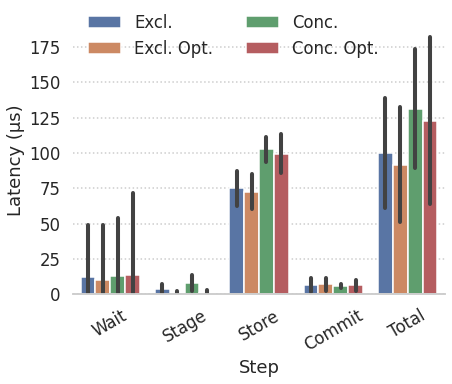

In [26]:
step_df_50 = prepare_breakdown(dataframes_50)
g = sns.catplot(x="Step", y="Latency in us", hue="Protocol", data=step_df_50, ci="sd", kind="bar",aspect=4./3, legend_out=False)
sns.despine(left=True)
g.set(ylim=(0, 190))
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='center')
    ax.set_ylabel("Latency (μs)")
    ax.legend(loc="best", ncol=2, bbox_to_anchor=(0.,0.1, 1, 1))
g.savefig("producer_breakdown_50.pdf", bbox_inches="tight", dpi=600)